In [11]:
from sys import path as syspath
from pathlib import Path

syspath.append(str(Path().home() / "pyref" / "src"))

In [12]:
import pyref as rf
from pypxr.structure import PXR_SLD, PXR_MaterialSLD
from pypxr.reflectivity import PXR_ReflectModel
from refnx.analysis import Transform, CurveFitter, Objective, GlobalObjective
from refnx._lib.emcee.moves.de import DEMove

# Experimental Configuration

In this notebook, we play arround with the idea that that the experiment could change in configuration between collecting s and p polarizaed data. Thus we will fit seperately s and p pol data and compare the results. 

C:\Users\Harlan Heilman\AppData\Local\Temp\ipykernel_23976\506948675.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s_pol = _s_pol[(_s_pol["Q"] != .0757)][_s_pol["Q"] != 0.0740]
C:\Users\Harlan Heilman\AppData\Local\Temp\ipykernel_23976\506948675.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_pol = _p_pol[(_p_pol["Q"] != .0757)][_p_pol["Q"] != 0.0740]


<Axes: xlabel='Q'>

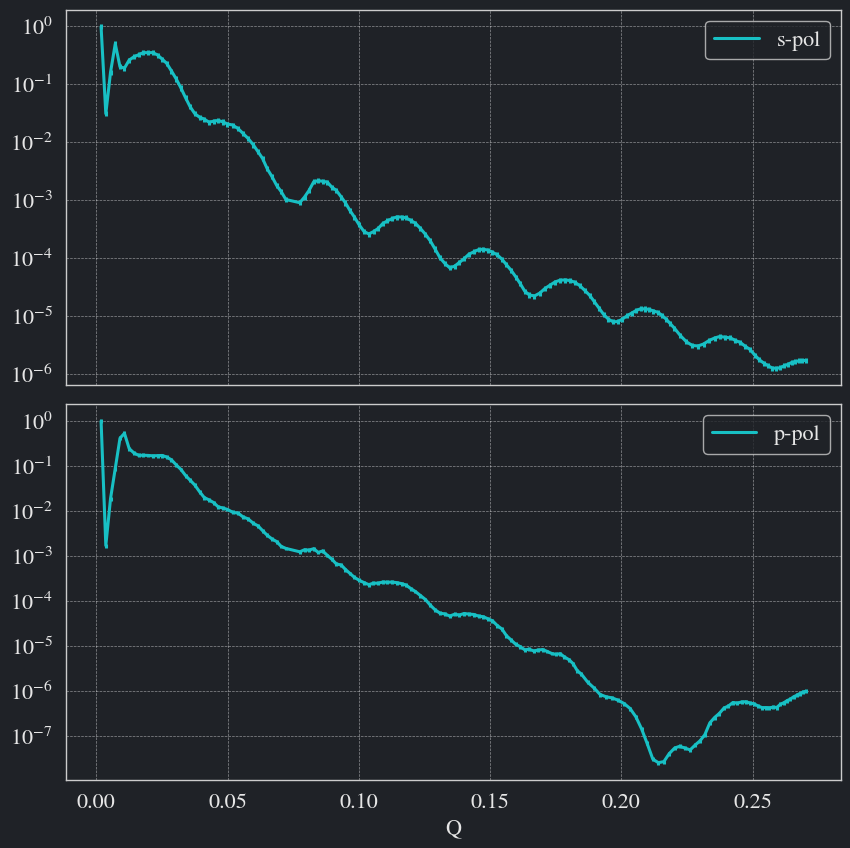

In [13]:
import matplotlib.pyplot as plt
db = rf.db()

#------------------------------------------------
# Load data
# Data loading is focused on the 283.7 ev data set
#------------------------------------------------

_s_pol = db.get_refl("ZnPc_283.7_100.0 (CCD Scan 82865).parquet", "ZnPc")
_p_pol = db.get_refl("ZnPc_283.7_190.0 (CCD Scan 82869).parquet", "ZnPc")

s_pol = _s_pol[(_s_pol["Q"] != .0757)][_s_pol["Q"] != 0.0740]
p_pol = _p_pol[(_p_pol["Q"] != .0757)][_p_pol["Q"] != 0.0740]

#------------------------------------------------
# Plot data
#------------------------------------------------

fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={"hspace": 0.05})
s_pol.plot(ax=ax[0], label="s-pol", x = "Q", y = "Refl", yerr = "Err", logy=True)
p_pol.plot(ax=ax[1], label="p-pol", x = "Q", y = "Refl", yerr = "Err", logy=True)

In [14]:
# Collect structure parameters
znpc_mono_struct_file = db.get_struct("ZnPc_RoomTemp")
znpc_oc = db.get_oc("C32H16N8Zn")

si_thick = znpc_mono_struct_file["Si"]["thickness"]
si_rough = znpc_mono_struct_file["Si"]["roughness"]
si_density = znpc_mono_struct_file["Si"]["density"]

sio2_thick = znpc_mono_struct_file["SiO2"]["thickness"]
sio2_rough = znpc_mono_struct_file["SiO2"]["roughness"]
sio2_density = znpc_mono_struct_file["SiO2"]["density"]

c_amor_thick = znpc_mono_struct_file["C"]["thickness"]
c_amor_rough = znpc_mono_struct_file["C"]["roughness"]
c_amor_density = znpc_mono_struct_file["C"]["density"]

znpc_thick = znpc_mono_struct_file["C32H16N8Zn"]["thickness"]
znpc_rough = znpc_mono_struct_file["C32H16N8Zn"]["roughness"]
znpc_density = znpc_mono_struct_file["C32H16N8Zn"]["density"]

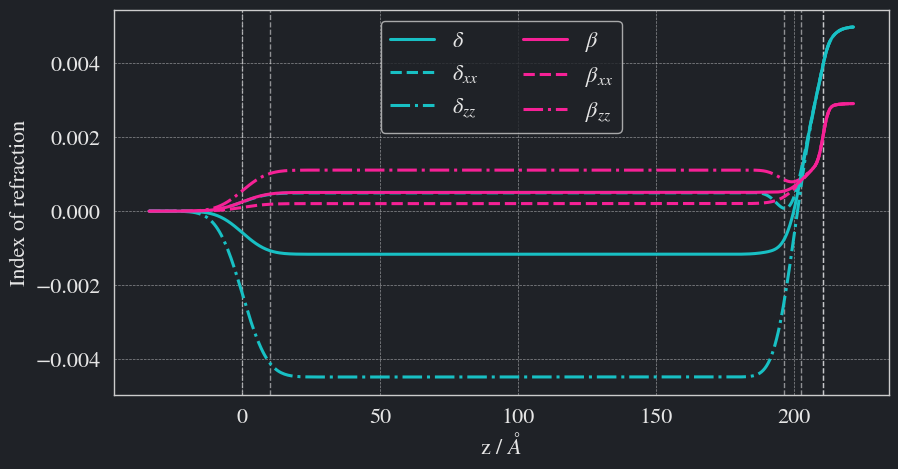

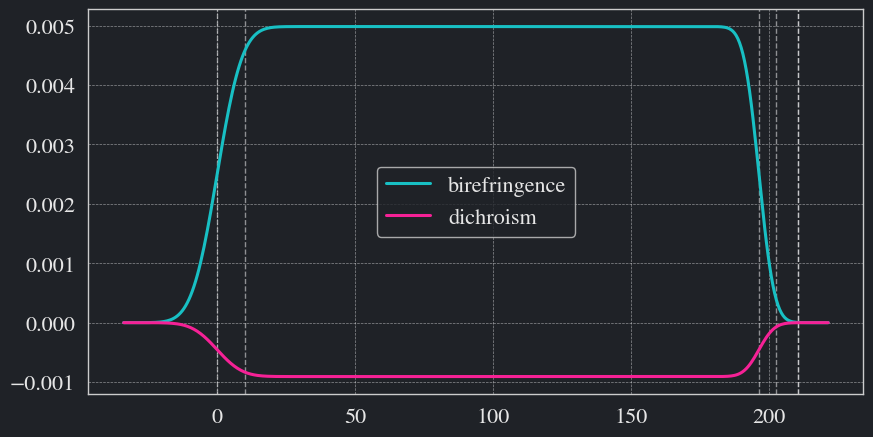

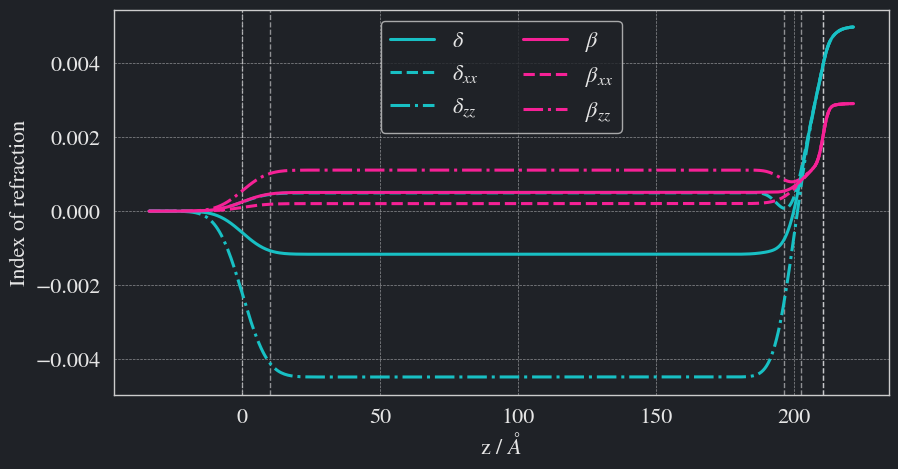

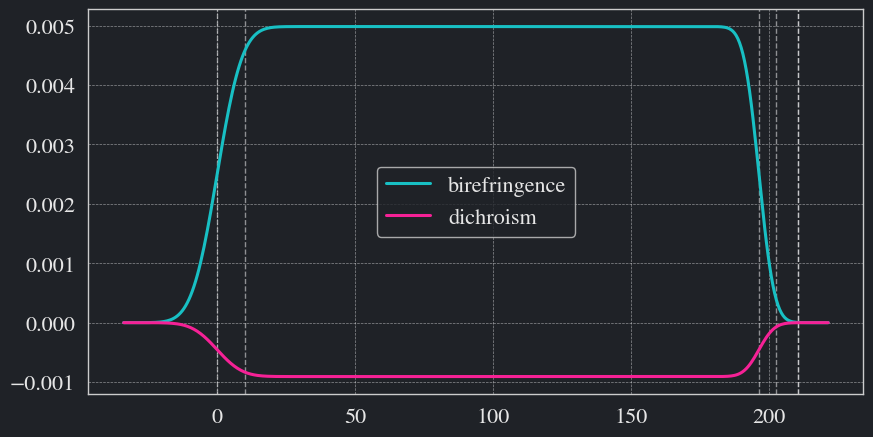

In [24]:
ens = [283.7, 283.7]

ns = znpc_oc(ens, density = znpc_density)


vac = [PXR_MaterialSLD("", 0, en)(0, 0) for en in ens]
si = [PXR_MaterialSLD("Si", 2.33, en, name="Si")(si_thick,si_rough) for en in ens]
sio2 = [PXR_MaterialSLD("SiO2", sio2_density, en, name="SiO2")(sio2_thick,sio2_rough) for en in ens]
c_amor = [PXR_MaterialSLD("C", c_amor_density, en, name="C_Amorphous")(c_amor_thick, c_amor_rough) for en in ens]

znpc_surf_thick = 10

znpc = [PXR_SLD(n, symmetry="uni", name = "ZnPc")(znpc_thick-znpc_surf_thick, znpc_rough) for _, n in zip(ens, ns)]

znpc_surf = [PXR_SLD(ns[i], symmetry="uni", name = "ZnPc_surf")(znpc_surf_thick, znpc_rough) for i, _ in enumerate(ens)]

# znpc_sub_surf = [PXR_SLD(ns[i], symmetry="uni", name = "ZnPc_sib_surf")(znpc_surf_thick, znpc_rough) for i, _ in enumerate(ens)]

# znpc_sub = [PXR_SLD(ns[i], symmetry="uni", name = "ZnPc_sub")(znpc_surf_thick, znpc_rough) for i, _ in enumerate(ens)]

structs = [vac[i] | znpc_surf[i] | znpc[i] | c_amor[i] | sio2[i] | si[i] for i in range(len(ens))]

for struc in structs:
    struc.plot(difference=True)


In [25]:
#------------------------------------------------
# Constrain Model
#------------------------------------------------
import numpy as np
for slab in si:
    slab.thick.setp(vary = False)
    slab.rough.setp(vary = False)

for slab in sio2:
    slab.thick.setp(vary = None, constraint = sio2_thick)
    slab.rough.setp(vary = None, constraint = sio2_rough)
    slab.sld.density.setp(vary = True, bounds = (0,3))

for slab in c_amor:
    slab.thick.setp(vary = None, constraint = c_amor_thick)
    slab.rough.setp(vary = None, constraint = c_amor_rough)
    slab.sld.density.setp(vary = True, bounds = (0,3))

for i, slab in enumerate(znpc):
    slab.thick.setp(vary = None, constraint = znpc_thick - znpc_surf[i].thick.value)
    slab.rough.setp(vary = True, bounds = (0, 10))

    slab.sld.xx.setp(vary = True, bounds = (0, 0.002))
    slab.sld.zz.setp(vary = True, bounds = (-.005,0))

    slab.sld.ixx.setp(vary=True, bounds = (0,.002))
    slab.sld.izz.setp(vary=True, bounds = (0,.002))

for slab in znpc_surf:
    slab.thick.setp(vary = True, bounds = (0, 20))
    slab.rough.setp(vary = True, bounds = (0, 10))

    slab.sld.xx.setp(vary = True, bounds = (-.005, .002))
    slab.sld.zz.setp(vary = True, bounds = (-.005, .002))

    slab.sld.ixx.setp(vary=True, bounds = (0,.002))
    slab.sld.izz.setp(vary=True, bounds = (0,.002))

# for slab in znpc_sub:
#     slab.thick.setp(vary = True, bounds = (0, 20))
#     slab.rough.setp(vary = True, bounds = (0, 10))

#     slab.sld.xx.setp(vary = True, bounds = (-.005, .002))
#     slab.sld.zz.setp(vary = True, bounds = (-.005, .002))

#     slab.sld.ixx.setp(vary=True, bounds = (0,.002))
#     slab.sld.izz.setp(vary=True, bounds = (0,.002))

# for slab in znpc_sub_surf:
#     slab.thick.setp(vary = True, bounds = (0, 20))
#     slab.rough.setp(vary = True, bounds = (0, 10))

#     slab.sld.xx.setp(vary = True, bounds = (-.005, .002))
#     slab.sld.zz.setp(vary = True, bounds = (-.005, .002))

#     slab.sld.ixx.setp(vary=True, bounds = (0,.002))
#     slab.sld.izz.setp(vary=True, bounds = (0,.002))

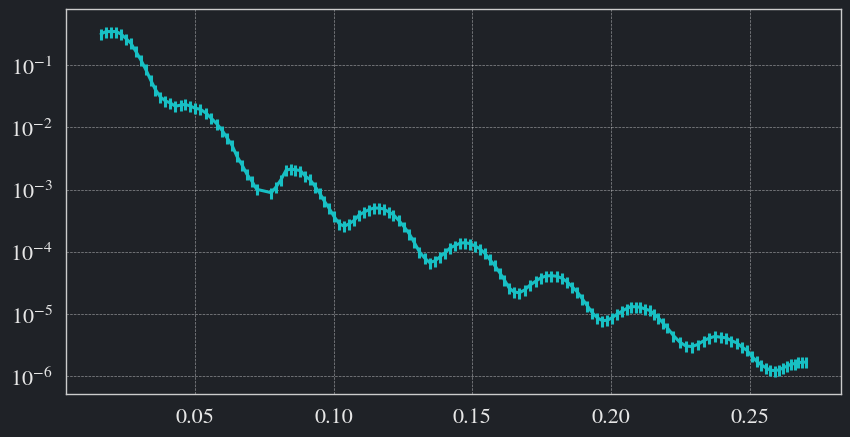

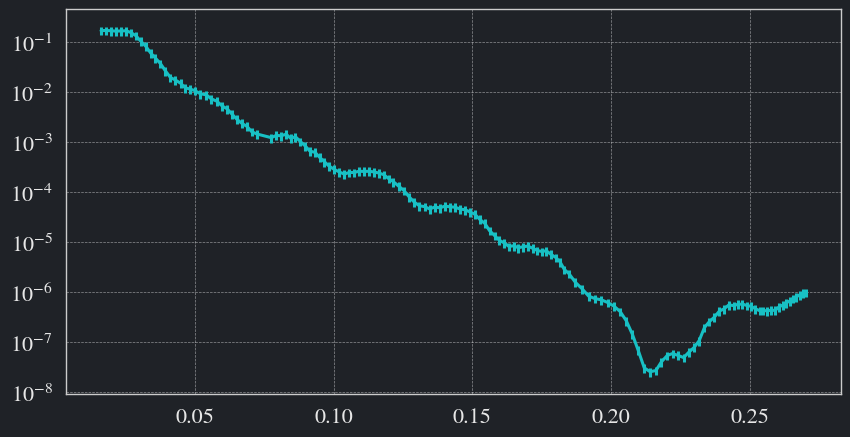

In [26]:
#------------------------------------------------
# Load Data
#------------------------------------------------

s_pol_ = s_pol.iloc[8:]
p_pol_ = p_pol.iloc[8:]

s_data = rf.to_refnx_dataset(s_pol_, pol = "s")
p_data = rf.to_refnx_dataset(p_pol_, pol = "p")

s_data.plot()
plt.yscale("log")
p_data.plot()
plt.yscale("log")

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

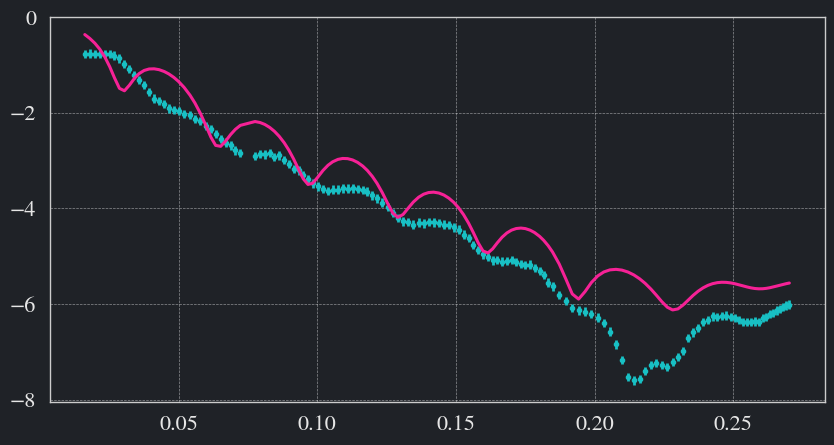

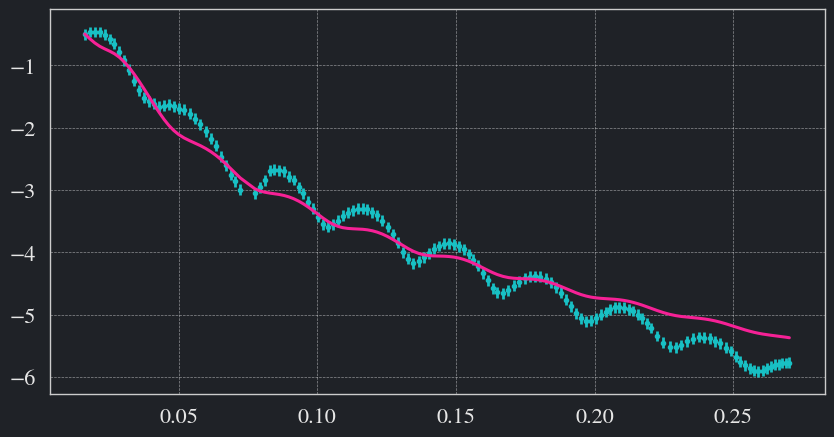

In [27]:
from pyref.fitting.logp import LogpExtra_rough

#------------------------------------------------
# p - polarized data
#------------------------------------------------

p_model = PXR_ReflectModel(structs[0], pol = "p", energy = ens[0], name = "ZnPc Mono Layer", theta_offset=-1)
p_model.scale.setp(vary = True, bounds = (0.5, 1.5))
p_model.bkg.setp(vary = True, bounds = (1e-12, p_pol["Refl"].min()))
p_model.theta_offset.setp(vary = True, bounds = (-2, 1))
p_model.en_offset.setp(vary = True, bounds = (-0.5, 0.5))

obj_p = Objective(p_model, p_data, transform=Transform("logY"))
lpe = LogpExtra_rough(obj_p)
obj_p.logp_extra = lpe

obj_p.plot()

#------------------------------------------------
# s - polarized data
#------------------------------------------------

s_model = PXR_ReflectModel(structs[1], pol = "s", dq = 0.0, energy = ens[1], name = "ZnPc Mono Layer")
s_model.scale.setp(vary = True, bounds = (0.5, 1.5))
s_model.bkg.setp(vary = True, bounds = (1e-12, s_pol["Refl"].min()))
s_model.theta_offset.setp(vary = True, bounds = (-2, 2))

obj_s = Objective(s_model, s_data, transform=Transform("logY"))
lpe = LogpExtra_rough(obj_s)
obj_s.logp_extra = lpe

obj_s.plot()

100%|██████████| 765/765 [01:00<00:00, 12.66it/s]


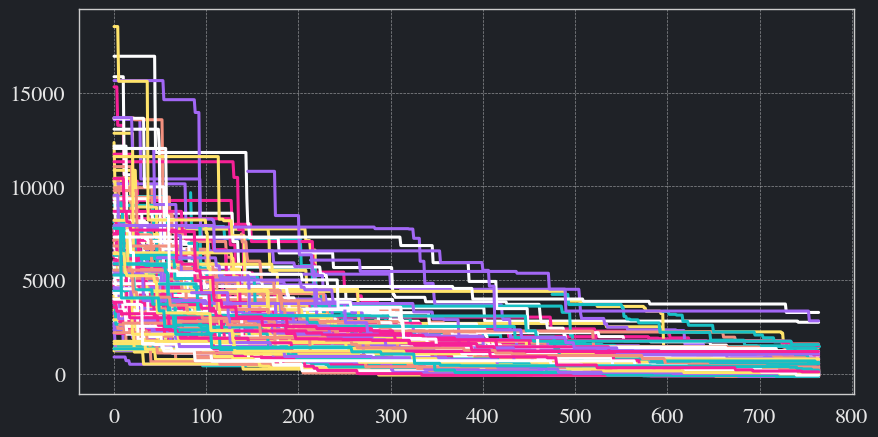

________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=0.730359 +/- 0.28 , bounds=[0.5, 1.5]>
<Parameter:     'bkg'     , value=1.25657e-08 +/- 8.54e-09, bounds=[1e-12, 2.5316362333630955e-08]>
<Parameter:  'en_offset'  , value=0.0151011 +/- 0.323, bounds=[-0.5, 0.5]>
<Parameter:'theta_offset' , value=-1.01239 +/- 0.84 , bounds=[-2.0, 1.0]>
<Parameter:'ZnPc_surf_thick', value=12.3829 +/- 6.25 , bounds=[0.0, 20.0]>
<Parameter:'ZnPc_surf_xx' , value=-0.000185104 +/- 0.00177, bounds=[-0.005, 0.002]>
<Parameter:'ZnPc_surf_ixx', value=0.00103553 +/- 0.000647, bounds=[0.0, 0.002]>
<Parameter:'ZnPc_surf_zz' , value=-0.0010969 +/- 0.00153, bounds=[-0.005, 0.002]>
<Parameter:'ZnPc_surf_izz', value=0.000838133 +/- 0.000621, bounds=[0.0, 0.002]>
<Parameter:'ZnPc_surf_rough', value=6.49347 +/- 3.34 , bounds=[0.0, 10.0]>
<Parameter:   'ZnPc_xx'   , value=0.000484021 +/- 0.000551, bounds=[0.0, 0.002]>
<Parameter:

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

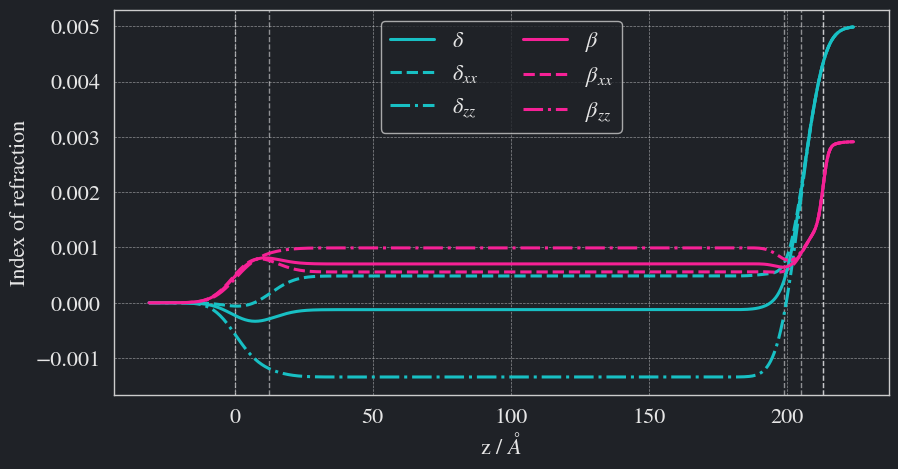

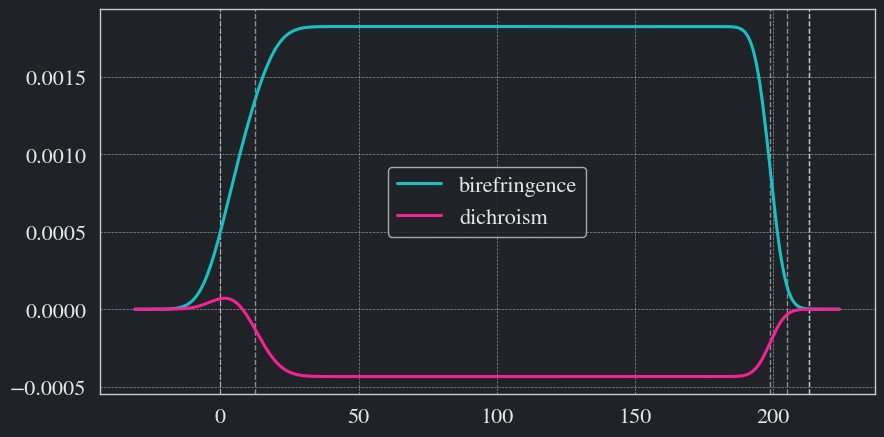

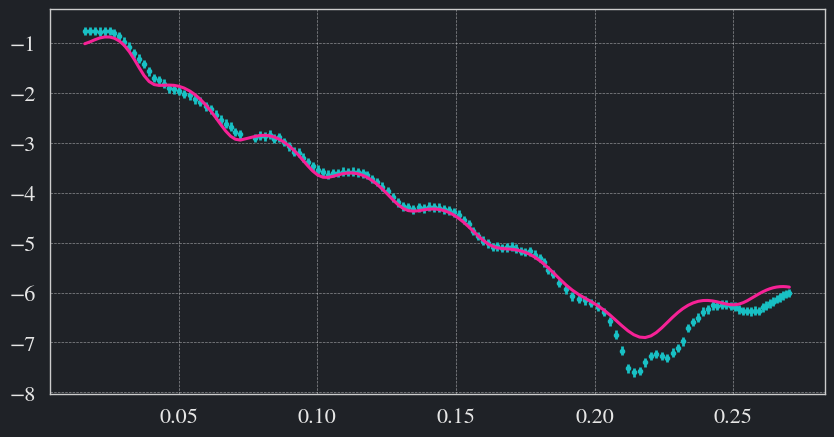

In [28]:
n_walkers = int(15*len(obj_p.varying_parameters()))
steps = 3*n_walkers

move = [(DEMove(sigma=1e-7), 0.95), (DEMove(sigma=1e-7, gamma0=1), 0.05)]
random_state = 120

fitter = CurveFitter(obj_p, nwalkers=n_walkers, moves = move)
fitter.initialise("prior")
chain = fitter.sample(steps, random_state=random_state)
lp = fitter.logpost
plt.plot(-lp)
plt.show()
structs[0].plot(difference=True)

print(obj_p.varying_parameters())
print(obj_p.chisqr())
obj_p.plot()

100%|██████████| 945/945 [01:21<00:00, 11.55it/s]


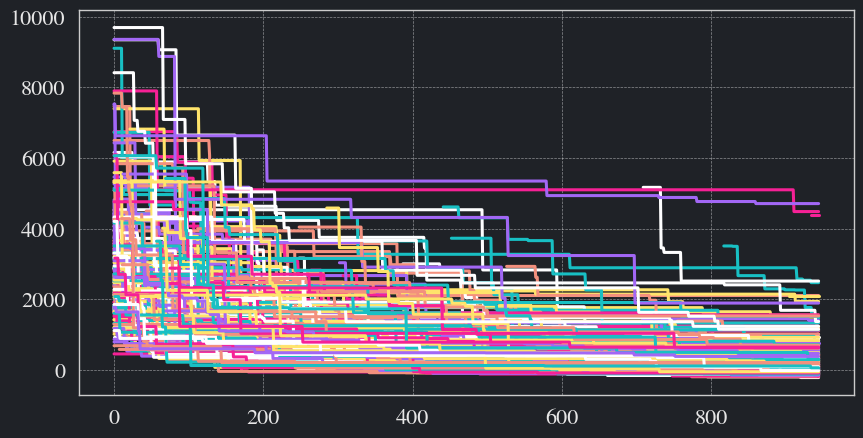

________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=0.574521 +/- 0.315, bounds=[0.2, 1.2]>
<Parameter:     'bkg'     , value=5.04696e-10 +/- 3.42e-10, bounds=[1e-12, 1e-09]>
<Parameter:'dq - resolution', value=0.246066 +/- 0.162, bounds=[0.0, 0.5]>
<Parameter:  'q_offset'   , value=-0.0102129 +/- 0.0103, bounds=[-0.02, 0.01]>
<Parameter:'ZnPc_surf_thick', value=11.3214 +/- 6.21 , bounds=[0.0, 20.0]>
<Parameter:'ZnPc_surf_xx' , value=-0.000680115 +/- 0.00184, bounds=[-0.005, 0.002]>
<Parameter:'ZnPc_surf_ixx', value=0.000955076 +/- 0.00063, bounds=[0.0, 0.002]>
<Parameter:'ZnPc_surf_zz' , value=-0.00168159 +/- 0.00239, bounds=[-0.005, 0.002]>
<Parameter:'ZnPc_surf_izz', value=0.000939384 +/- 0.000685, bounds=[0.0, 0.002]>
<Parameter:'ZnPc_surf_rough', value=5.02732 +/- 3.32 , bounds=[0.0, 10.0]>
<Parameter:   'ZnPc_xx'   , value=0.000843189 +/- 0.000666, bounds=[0.0, 0.002]>
<Parameter:  'ZnPc_ixx

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

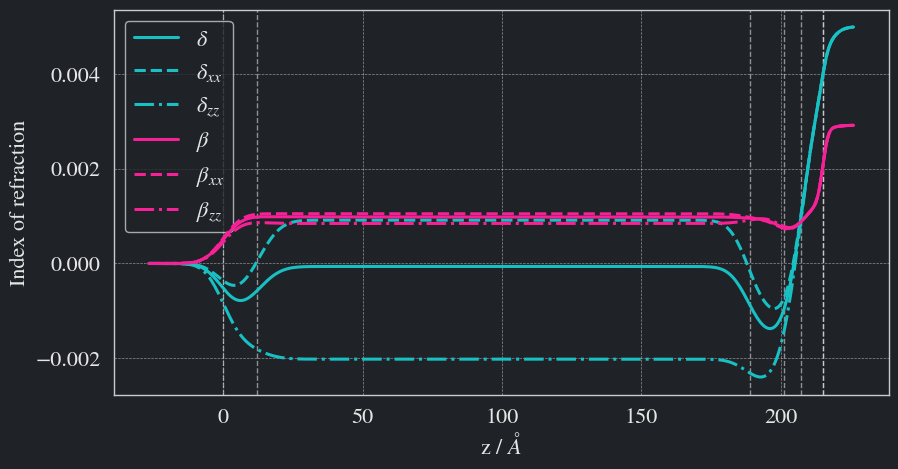

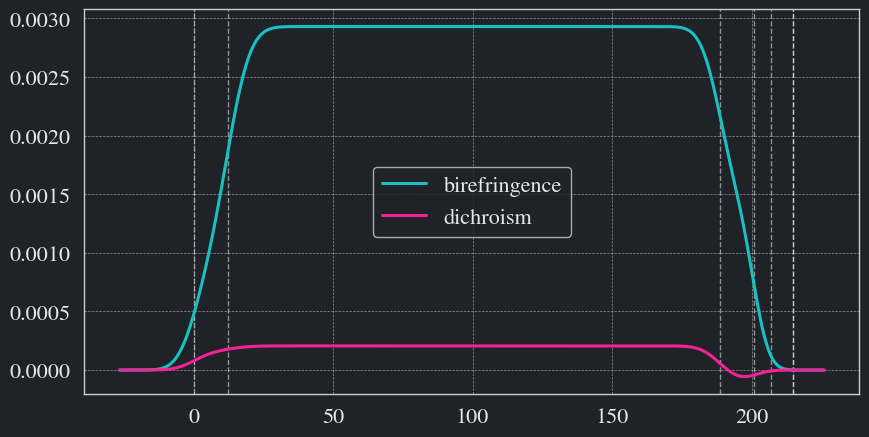

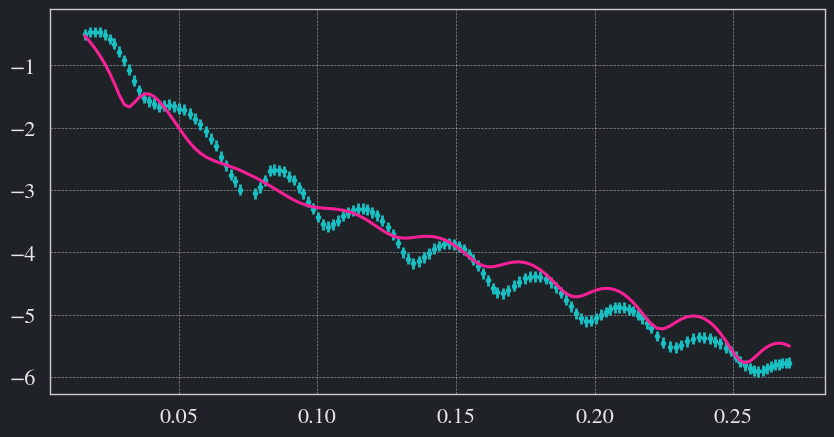

In [16]:
fitter = CurveFitter(obj_s, nwalkers=n_walkers, moves = move)
fitter.initialise("prior")
chain = fitter.sample(steps, random_state=random_state)
lp = fitter.logpost
plt.plot(-lp)
plt.show()
structs[0].plot(difference=True)

print(obj_s.varying_parameters())
print(obj_s.chisqr())
obj_s.plot()